## Libraries

In [26]:
import numpy as np
import sympy as sym
import cmath as cm
import random as rand
import matplotlib.pyplot as plt
import math as m

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Simulation 

### Changing N (Number of Trials)


In [27]:
def Creating_states(coeff, Abstract=False):
    if Abstract:
        a0, a1, b0, b1 = sym.symbols('a0 a1 b0 b1')
    else:
        a0, a1, b0, b1 = coeff
    return [[a0, a1], [b0, b1]]

def square_state(psi):
    psi_sq = [i*j for i in psi for j in psi]
    return [psi_sq[0], (psi_sq[1]**2 + psi_sq[2]**2)**0.5, psi_sq[3]]

def create_POVM_vectors():
    w = m.e**((2/3)*m.pi*(1j))
    return (1/(2**0.5)) * np.array([
        [0,1,-1], [-1,0,1], [1,-1,0], [0,w,-w**2], [-1,0,w**2], 
        [1,-w,0], [0,w**2,-w], [-1,0,w], [1,-w**2,0]])

def create_POVM_elements(POVM_vec):
    return [(1/3)*np.outer(np.conjugate(vec), vec) for vec in POVM_vec]

def create_M_matrix(POVM_elts):
    return [[np.trace(np.dot(elts_i, elts_j)) for elts_i in POVM_elts] for elts_j in POVM_elts]

def create_inverse_matrix(u_0):
    return 3*np.outer(u_0, u_0) + 12*(np.eye(9) - np.outer(u_0, u_0))


def calculate_prob_vector(rho, POVM_elts):
    prob_vec = [np.trace(np.dot(elts, rho)).real for elts in POVM_elts]
    return [p for p in prob_vec if abs(p.imag) < 0.01]

def calculate_rho_exp(r_vec, POVM_elts):
    rho_exp_list = [r_vec[i] * POVM_elts[i] for i in range(len(POVM_elts))]
    rho_exp = sum(rho_exp_list, np.zeros_like(rho_exp_list[0]))
    return rho_exp


In [28]:
def run_sim(N, coeff, priors, POVM_elts, M_inv):
    states = Creating_states(coeff, Abstract=False)
    psi0, psi1 = states
    psi0_sq = square_state(psi0)
    psi1_sq = square_state(psi1)

    psi0_psi0_vec = np.array(psi0_sq)
    psi1_psi1_vec = np.array(psi1_sq)

    rho = priors[0]*np.outer(psi0_psi0_vec, psi0_psi0_vec) + priors[1]*np.outer(psi1_psi1_vec, psi1_psi1_vec)
    
    prob_vec = calculate_prob_vector(rho, POVM_elts)
    POVM_directions = [f'd{i+1}' for i in range(9)]
    collabse_directions = rand.choices(POVM_directions, weights=prob_vec, k=N)

    nj_vec = [collabse_directions.count(f'd{i+1}') for i in range(9)]
    pj_sim_vec = [i/N for i in nj_vec]

    r_vec = np.dot(M_inv, pj_sim_vec)
    rho_exp = calculate_rho_exp(r_vec, POVM_elts)
    
    rho_diff = np.subtract(rho, rho_exp)
    eigenvalues, _ = np.linalg.eig(rho_diff)
    evals = np.array([i.real for i in eigenvalues if abs(i.imag) < 0.01])
    error = max([abs(i) for i in evals])

    return error

Run the simulation 

In [29]:
def plot_results(x_data, y_data, labels, titles, x_label, y_label, plot_type='single', subplot_titles=None):
    if plot_type == 'single':
        plt.plot(x_data, y_data[0], label=labels[0])
        plt.plot(x_data, y_data[1], "--", label=labels[1])
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(titles[0])
        plt.legend()
        plt.show()
    elif plot_type == 'double':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
        ax1.plot(x_data, y_data[0], label=labels[0])
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(y_label)
        ax1.set_title(subplot_titles[0])
        ax1.legend(loc='best')

        ax2.plot(x_data, y_data[1], label=labels[1])
        ax2.set_xlabel(x_label)
        ax2.set_ylabel(y_label)
        ax2.set_title(subplot_titles[1])
        ax2.legend(loc='best')
        
        plt.show()


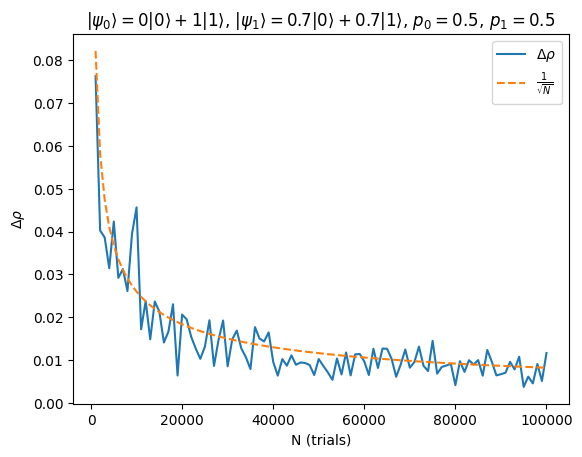

Error Converged to: 0.00503385189772602


In [30]:
POVM_vec = create_POVM_vectors()  #
POVM_elts = create_POVM_elements(POVM_vec)
M = create_M_matrix(POVM_elts)
u_0 = [1/3 for _ in range(9)]
M_inv = create_inverse_matrix(u_0)

coeff = [0, 1, 1/(2**0.5), 1/(2**0.5)]
priors = [0.5, 0.5]
trials = [1000*(i+1) for i in range(100)]

errors = [run_sim(i, coeff, priors, POVM_elts, M_inv) for i in trials]
sqrtN = [2.6/(i**0.5) for i in trials]

plot_results(trials, [errors, sqrtN], 
             [r'$\Delta \rho $', r'$\frac{1}{\sqrt{N}}$'], 
             [r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $p_0={},\,p_1={}$'.format(*[round(c, 1) for c in coeff], *priors)],
             'N (trials)', r'$\Delta \rho $')

print(f'Error Converged to:', run_sim(1000*100, coeff, priors, POVM_elts, M_inv))

### Changing p0

In [31]:
def run_sim(N, coeff, p0, POVM_elts, M_inv):
    p1 = 1 - p0  # p1 is determined by p0
    priors = [p0, p1]

    states = Creating_states(coeff, Abstract=False)
    psi0, psi1 = states
    psi0_sq = square_state(psi0)
    psi1_sq = square_state(psi1)

    psi0_psi0_vec = np.array(psi0_sq)
    psi1_psi1_vec = np.array(psi1_sq)

    rho = priors[0]*np.outer(psi0_psi0_vec, psi0_psi0_vec) + priors[1]*np.outer(psi1_psi1_vec, psi1_psi1_vec)
    
    prob_vec = calculate_prob_vector(rho, POVM_elts)
    POVM_directions = [f'd{i+1}' for i in range(9)]
    collabse_directions = rand.choices(POVM_directions, weights=prob_vec, k=N)

    nj_vec = [collabse_directions.count(f'd{i+1}') for i in range(9)]
    pj_sim_vec = [i/N for i in nj_vec]

    r_vec = np.dot(M_inv, pj_sim_vec)
    rho_exp = calculate_rho_exp(r_vec, POVM_elts)
    
    rho_diff = np.subtract(rho, rho_exp)
    eigenvalues, _ = np.linalg.eig(rho_diff)
    evals = np.array([i.real for i in eigenvalues if abs(i.imag) < 0.01])
    error = max([abs(i) for i in evals])

    return error

In [32]:
def plot_errors_vs_p0(N, coeff, POVM_elts, M_inv, p0_values):
    errors = []
    for p0 in p0_values:
        error = run_sim(N, coeff, p0, POVM_elts, M_inv)
        errors.append(error)
    
    plt.plot(p0_values, errors)
    plt.xlabel(r'$p_0$')
    plt.ylabel(r'$\Delta \rho$')
    plt.title('Error vs. $p_0$')
    plt.show()

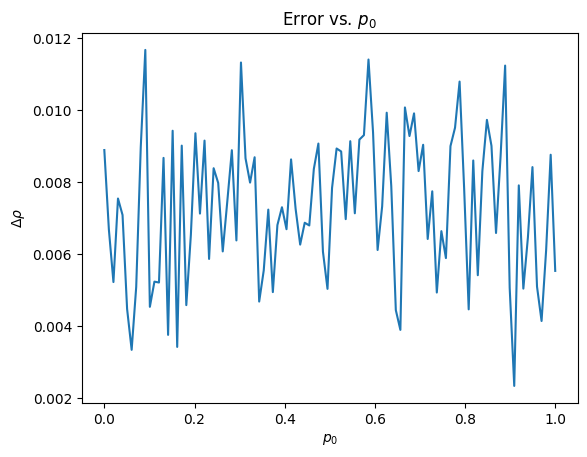

In [33]:
# Preparing POVM elements and inverse matrix
POVM_vec = create_POVM_vectors()
POVM_elts = create_POVM_elements(POVM_vec)
M = create_M_matrix(POVM_elts)
u_0 = [1/3 for _ in range(9)]
M_inv = create_inverse_matrix(u_0)

# Coefficients for the states
coeff = [0, 1, 1/(2**0.5), 1/(2**0.5)]

# Varying p0 and plotting the results
p0_values = np.linspace(0, 1, 100)  # Varying p0 from 0 to 1
N = 1000 * 100  # Number of trials
plot_errors_vs_p0(N, coeff, POVM_elts, M_inv, p0_values)

## Largest Eigenvalue and normalization

### Changing N (Number of Trials)

In [34]:
def calculate_largest_eigenvalue_difference(N, coeff, priors, POVM_elts, M_inv):
    states = Creating_states(coeff, Abstract=False)
    psi0, psi1 = states
    psi0_sq = square_state(psi0)
    psi1_sq = square_state(psi1)

    psi0_psi0_vec = np.array(psi0_sq)
    psi1_psi1_vec = np.array(psi1_sq)

    rho_theo = priors[0]*np.outer(psi0_psi0_vec, psi0_psi0_vec) + priors[1]*np.outer(psi1_psi1_vec, psi1_psi1_vec)
    
    prob_vec = calculate_prob_vector(rho_theo, POVM_elts)
    POVM_directions = [f'd{i+1}' for i in range(9)]
    collabse_directions = rand.choices(POVM_directions, weights=prob_vec, k=N)

    nj_vec = [collabse_directions.count(f'd{i+1}') for i in range(9)]
    pj_sim_vec = [i/N for i in nj_vec]

    r_vec = np.dot(M_inv, pj_sim_vec)
    rho_exp = calculate_rho_exp(r_vec, POVM_elts)
    
    rho_diff = np.subtract(rho_theo, rho_exp)
    eigenvalues, _ = np.linalg.eig(rho_diff)
    evals = np.array([i.real for i in eigenvalues if abs(i.imag) < 0.01])
    largest_eigenvalue = max([abs(i) for i in evals])

    return largest_eigenvalue

In [35]:
def plot_largest_eigenvalue_vs_N(trials, coeff, priors, POVM_elts, M_inv):
    largest_eigenvalues = [calculate_largest_eigenvalue_difference(N, coeff, priors, POVM_elts, M_inv) for N in trials]

    plt.plot(trials, largest_eigenvalues)
    plt.xlabel('N (trials)')
    plt.ylabel('Largest Eigenvalue of $\\rho_{diff}$')
    plt.title('Largest Eigenvalue vs. N')
    plt.show()

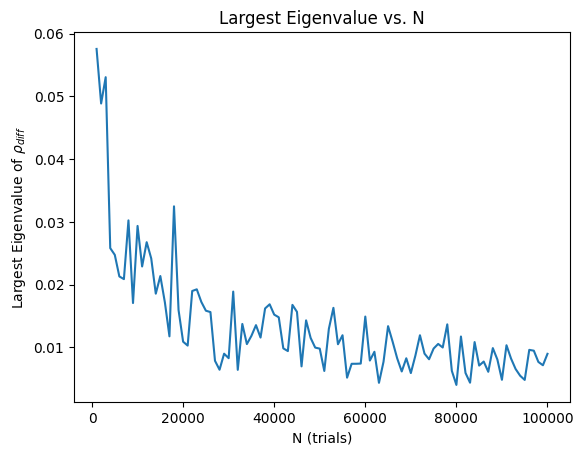

In [36]:
# Preparing POVM elements and inverse matrix
POVM_vec = create_POVM_vectors()
POVM_elts = create_POVM_elements(POVM_vec)
M = create_M_matrix(POVM_elts)
u_0 = [1/3 for _ in range(9)]
M_inv = create_inverse_matrix(u_0)

# Coefficients for the states and priors
coeff = [0, 1, 1/(2**0.5), 1/(2**0.5)]
priors = [0.5, 0.5]

# Varying N (number of trials) and plotting the results
trials = [1000*(i+1) for i in range(100)]
plot_largest_eigenvalue_vs_N(trials, coeff, priors, POVM_elts, M_inv)

### Changing p0

In [37]:
def calculate_largest_eigenvalue_difference(N, coeff, p0, POVM_elts, M_inv):
    p1 = 1 - p0
    priors = [p0, p1]

    states = Creating_states(coeff, Abstract=False)
    psi0, psi1 = states
    psi0_sq = square_state(psi0)
    psi1_sq = square_state(psi1)

    psi0_psi0_vec = np.array(psi0_sq)
    psi1_psi1_vec = np.array(psi1_sq)

    rho_theo = priors[0]*np.outer(psi0_psi0_vec, psi0_psi0_vec) + priors[1]*np.outer(psi1_psi1_vec, psi1_psi1_vec)
    
    prob_vec = calculate_prob_vector(rho_theo, POVM_elts)
    POVM_directions = [f'd{i+1}' for i in range(9)]
    collabse_directions = rand.choices(POVM_directions, weights=prob_vec, k=N)

    nj_vec = [collabse_directions.count(f'd{i+1}') for i in range(9)]
    pj_sim_vec = [i/N for i in nj_vec]

    r_vec = np.dot(M_inv, pj_sim_vec)
    rho_exp = calculate_rho_exp(r_vec, POVM_elts)
    
    rho_diff = np.subtract(rho_theo, rho_exp)
    eigenvalues, _ = np.linalg.eig(rho_diff)
    evals = np.array([i.real for i in eigenvalues if abs(i.imag) < 0.01])
    largest_eigenvalue = max([abs(i) for i in evals])

    return largest_eigenvalue

In [38]:
def plot_largest_eigenvalue_vs_p0(N, coeff, POVM_elts, M_inv, p0_values):
    largest_eigenvalues = [calculate_largest_eigenvalue_difference(N, coeff, p0, POVM_elts, M_inv) for p0 in p0_values]

    plt.plot(p0_values, largest_eigenvalues)
    plt.xlabel('$p_0$')
    plt.ylabel('Largest Eigenvalue of $\\rho_{diff}$')
    plt.title('Largest Eigenvalue vs. $p_0$')
    plt.show()


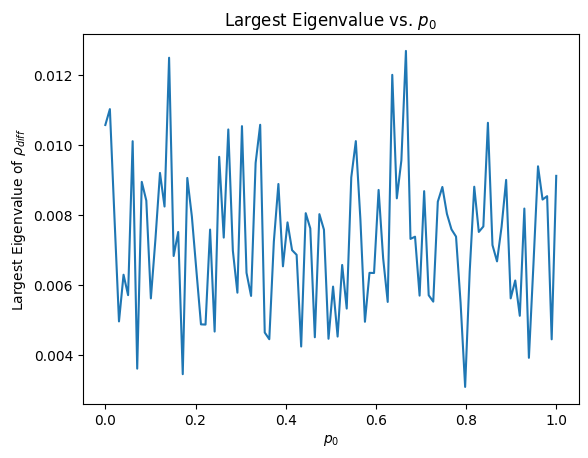

In [39]:
# Preparing POVM elements and inverse matrix
POVM_vec = create_POVM_vectors()
POVM_elts = create_POVM_elements(POVM_vec)
M = create_M_matrix(POVM_elts)
u_0 = [1/3 for _ in range(9)]
M_inv = create_inverse_matrix(u_0)

# Coefficients for the states
coeff = [0, 1, 1/(2**0.5), 1/(2**0.5)]

# Fixed number of trials
N = 1000 * 100

# Varying p0 and plotting the results
p0_values = np.linspace(0, 1, 100)  # Varying p0 from 0 to 1
plot_largest_eigenvalue_vs_p0(N, coeff, POVM_elts, M_inv, p0_values)

## Fidelity 

In [40]:
def solve_quadratic(a, b, c=0):
    """Solve quadratic equation and return solutions."""
    d = (b**2) - (4*a*c)
    sol1 = (-b-cm.sqrt(d))/(2*a)
    sol2 = (-b+cm.sqrt(d))/(2*a)
    return sol1, sol2

def solve_quadratic(a, b, c):
    """Solve quadratic equation and return solutions."""
    d = (b**2) - (4*a*c)
    sol1 = (-b-cm.sqrt(d))/(2*a)
    sol2 = (-b+cm.sqrt(d))/(2*a)
    return sol1, sol2


In [41]:
def calculate_probabilities(POVM_elts, rho):
    """Calculate and return probability vector."""
    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(len(POVM_elts))]
    return [i.real for i in prob_vec if abs(i.imag) < 0.01]

def simulate_collapse_directions(prob_vec, N):
    """Simulate collapse directions."""
    POVM_directions = [f'd{i+1}' for i in range(len(prob_vec))]
    return rand.choices(POVM_directions, weights=prob_vec, k=N)

def calculate_rho_exp(r_vec, POVM_elts):
    """Calculate and return the expected rho."""
    rho_exp_list =  [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]
    rho_exp = np.zeros_like(rho_exp_list[0])
    for m in rho_exp_list:
        rho_exp = np.add(rho_exp, m)
    return rho_exp

In [42]:
def calculate_fidelity(coefficients):
    f0_t =  np.conj(coefficients[0])/np.conj(coefficients[1])
    f1_t =  np.conj(coefficients[2])/np.conj(coefficients[3])
    return f0_t, f1_t

def calculate_simulation_vectors(states):
    simulation_vectors = []
    for state in states:
        # Ensure the state has enough elements
        if len(state) >= 4:
            simulation_vector = [state[0], (state[1]**2 + state[2]**2)**0.5, state[3]]
            simulation_vectors.append(simulation_vector)
        else:
            raise ValueError("State vector does not have enough elements")
    return simulation_vectors

def calculate_rho_exp(POVM_elts, r_vec):
    rho_exp_list =  [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]
    rho_exp = np.zeros_like(rho_exp_list[0])
    for m in rho_exp_list:
        rho_exp = np.add(rho_exp,m)
    return rho_exp

def calculate_psi(coeff, f0_t, f1_t):
    if (f0_t<=f1_t):
        a0 = abs(f1_t)/(np.sqrt(1+ (abs(f1_t))**2))
        a1 = 1/(np.sqrt(1+ (abs(f1_t))**2))
        b0 = abs(f0_t)/(np.sqrt(1+ (abs(f0_t))**2))
        b1 = 1/(np.sqrt(1+ (abs(f0_t))**2)) 
    else:
        a0 = abs(f0_t)/(np.sqrt(1+ (abs(f0_t))**2))
        a1 = 1/(np.sqrt(1+ (abs(f0_t))**2))
        b0 = abs(f1_t)/(np.sqrt(1+ (abs(f1_t))**2))
        b1 = 1/(np.sqrt(1+ (abs(f1_t))**2))
    psi0_sim = [a0,a1]
    psi1_sim = [b0,b1]
    return psi0_sim, psi1_sim

In [43]:
def compute_fidelities(coeff, priors, POVM_elts, M_inv, N):
    """Compute and return fidelities."""
    states = Creating_states(coeff)
    psi0, psi1 = states[0], states[1]
    
    f0_t = np.conj(psi0[0])/np.conj(psi0[1])
    f1_t = np.conj(psi1[0])/np.conj(psi1[1])
    
    psi0_sq = []
    psi1_sq = []
    [[psi0_sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1_sq.append(i*j) for i in psi1] for j in psi1]
    psi0psi0 = [psi0_sq[0], (psi0_sq[1]**2 + psi0_sq[2]**2)**.5, psi0_sq[3]]
    psi1psi1 = [psi1_sq[0], (psi1_sq[1]**2 + psi1_sq[2]**2)**.5, psi1_sq[3]]
    psi0_psi0_vec = np.array(psi0psi0)
    psi1_psi1_vec = np.array(psi1psi1)
    rho = priors[0]*np.outer(psi0_psi0_vec, psi0_psi0_vec) + priors[1]*np.outer(psi1_psi1_vec, psi1_psi1_vec)
    
    # Calculate probability vector
    prob_vec = calculate_probabilities(POVM_elts, rho)
    
    collabse_directions = simulate_collapse_directions(prob_vec, N)
    nj_vec = [collabse_directions.count(f'd{i+1}') for i in range(9)]
    pj_sim_vec = [i/N for i in nj_vec]
    r_vec = np.dot(M_inv, pj_sim_vec)
    
    rho_exp = calculate_rho_exp(r_vec, POVM_elts)
    
    # Calculate the eigenvalues and eigenstates of rho_exp
    eigenvalues, eigenstates = np.linalg.eig(rho_exp)
    evals = np.array([i.real for i in eigenvalues if abs(i.imag) < 0.01])
    matrix_index = np.argmin(evals)
    eigen_vec = eigenstates[:, matrix_index]
    
    # Construct the C00, C01, and C11 coefficients
    c00 = eigen_vec[0]
    c01 = eigen_vec[1]
    c11 = eigen_vec[2]
    # print the coefficients
    #print(f'C00 = {c00}, C01 = {c01}, C11 = {c11}') # for debugging only
    
    # Calculate the fidelity
    f0, f1 = solve_quadratic(c00, c01, c11)
    
    # Construct psi from f0 and f1
    if f0_t <= f1_t:
        a0 = abs(f1)/(np.sqrt(1 + abs(f1)**2))
        a1 = 1/(np.sqrt(1 + abs(f1)**2))
        b0 = abs(f0)/(np.sqrt(1 + abs(f0)**2))
        b1 = 1/(np.sqrt(1 + abs(f0)**2)) 
    else:
        a0 = abs(f0)/(np.sqrt(1 + abs(f0)**2))
        a1 = 1/(np.sqrt(1 + abs(f0)**2))
        b0 = abs(f1)/(np.sqrt(1 + abs(f1)**2))
        b1 = 1/(np.sqrt(1 + abs(f1)**2))

    psi0_sim = [a0, a1]
    psi1_sim = [b0, b1]

    # Get psi0 and psi1 from coeff
    psi0 = [coeff[0], coeff[1]]
    psi1 = [coeff[2], coeff[3]]
    
    # Calculate the fidelity
    fid0 = abs(np.dot(np.conj(psi0), psi0_sim))**2
    fid1 = abs(np.dot(np.conj(psi1), psi1_sim))**2
    fid = [fid0, fid1]

    return fid


In [44]:
def plot_fidelities(trials, output):
    """Plot the fidelities."""
    output_t = list(map(list, zip(*output)))  # Transpose of output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

    # Format the coefficients and priors with 2 decimal places
    coeff_formatted = [f'{c:.2f}' for c in coeff]
    priors_formatted = [f'{p:.2f}' for p in priors]

    ax1.plot(trials, output_t[0], label=r'$F_0=|\langle \psi_0|\psi_0^{\,n}\rangle|^2$')
    ax1.set_xlabel('N (trials)')
    ax1.set_ylabel('Fidelity F')
    ax1.set_title(f'$|\\psi_0\\rangle = {coeff_formatted[0]}|0\\rangle + {coeff_formatted[1]}|1\\rangle$, $p_0 = {priors_formatted[0]}$')
    ax1.legend(loc='best')

    ax2.plot(trials, output_t[1], label=r'$F_1=|\langle \psi_1|\psi_1^{\,n}\rangle|^2$')
    ax2.set_xlabel('N (trials)')
    ax2.set_title(f'$|\\psi_1\\rangle = {coeff_formatted[2]}|0\\rangle + {coeff_formatted[3]}|1\\rangle$, $p_1 = {priors_formatted[1]}$')
    ax2.legend(loc='best')

    plt.show()


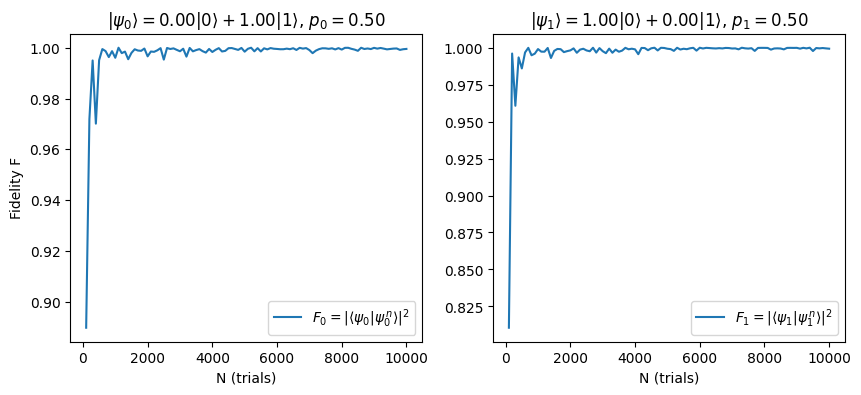

In [45]:
POVM_vec = create_POVM_vectors()  #
POVM_elts = create_POVM_elements(POVM_vec)
M = create_M_matrix(POVM_elts)
u_0 = [1/3 for _ in range(9)]
M_inv = create_inverse_matrix(u_0)


#coeff = [1/(2**.5), 1/(2**.5), 1/(2**.5), 1/(2**.5)]  # Example coefficients
coeff = [0, 1, 1, 0]
priors = [.5, .5]
trials = [100*(i+1) for i in range(100)]


output = [compute_fidelities(coeff, priors, POVM_elts, M_inv, i) for i in trials]
plot_fidelities(trials, output)

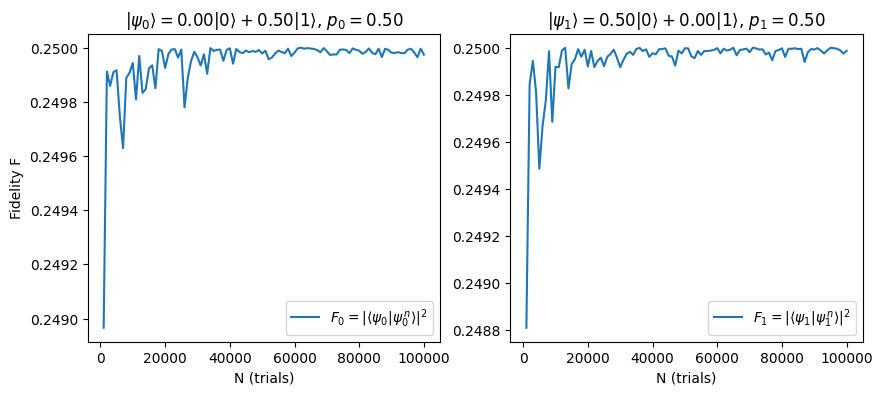

In [46]:
POVM_vec = create_POVM_vectors()  #
POVM_elts = create_POVM_elements(POVM_vec)
M = create_M_matrix(POVM_elts)
u_0 = [1/3 for _ in range(9)]
M_inv = create_inverse_matrix(u_0)


coeff = [0, 0.5, 0.5, 0.0]  # Example coefficients
priors = [.5, .5]
trials = [1000*(i+1) for i in range(100)]


output = [compute_fidelities(coeff, priors, POVM_elts, M_inv, i) for i in trials]
plot_fidelities(trials, output)

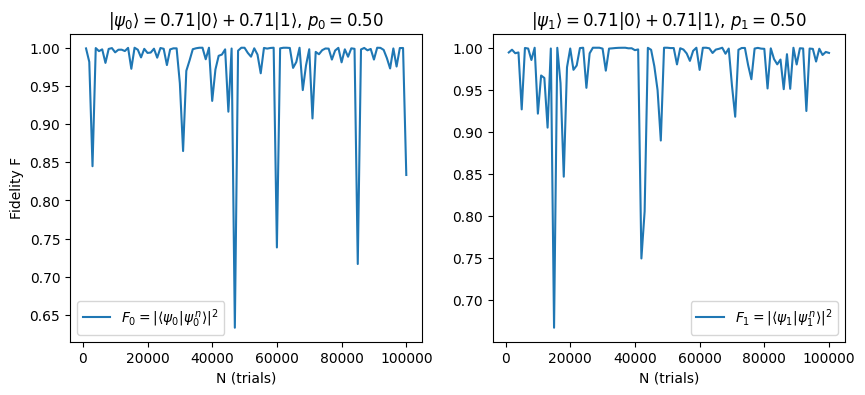

In [47]:
POVM_vec = create_POVM_vectors()  #
POVM_elts = create_POVM_elements(POVM_vec)
M = create_M_matrix(POVM_elts)
u_0 = [1/3 for _ in range(9)]
M_inv = create_inverse_matrix(u_0)


coeff = [1/(2**.5), 1/(2**.5), 1/(2**.5), 1/(2**.5)]  # Example coefficients
priors = [.5, .5]
trials = [1000*(i+1) for i in range(100)]


output = [compute_fidelities(coeff, priors, POVM_elts, M_inv, i) for i in trials]
plot_fidelities(trials, output)